# Time Series Predictions using Deep Learning

## Technical Indicators to consider

The Technical Indicators are:
- RSI
  - $RSI_{step1} = 100 - \frac{100}{1 + \frac{Average Gain}{Average Loss}}$
- Stochastic K
  - $K\% = \frac{C - L14}{H14 - L14} * 100$
- MACD
- CCI
  - $CCI = \frac{1}{0.015} * \frac{p_t - SMA(p_t)}{MD(p_t)}$
  - Here, $p_t = \frac{p_{high} + p_{low} + p_{close}}{3}$
  
- ATR
- Bollinger Bands



In [ ]:
!pip install alpha_vantage

     |████████████████████████████████| 1.2MB 5.0MB/s 
     |████████████████████████████████| 256kB 14.8MB/s 
     |████████████████████████████████| 153kB 21.3MB/s 
  Created wheel for alpha-vantage: filename=alpha_vantage-2.2.0-cp36-none-any.whl size=25705 sha256=ae1bf702c4068f702de19b601749fc277118a970166346bd73c6e84cc607cddb
  Stored in directory: /root/.cache/pip/wheels/3a/fa/05/80b0afcbd2a4de8bd2a0c5cd77084e3d3a9cc12c48be9b7f84
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=2dde67af7df552eee4a914a04cdb1f3c62172f15b9cda3bb891a39bd531f5dbe
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built alpha-vantage idna-ssl


In [ ]:
import pandas as pd
import numpy as np
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries

import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
fig.show()

import time

In [ ]:
# Constants
API_SECRET = "644PPK94BTG0W6XS"
ibm_fpath = "C:\\Users\\ADMIN\\Desktop\\CQF-Project\\CQF_Elective__Machine_Learning_with_Python_-_Python_Notebooks\\karthik_jagadeesan_DL_LSTM_Project\\ibm.csv"

In [ ]:
b = TechIndicators(key = API_SECRET, output_format = 'pandas')
rsi = b.get_rsi(symbol = "IBM", interval = "daily", time_period = 14)

In [ ]:
def get_df(security):
  b = TechIndicators(key = API_SECRET, output_format = "pandas")
  sma = b.get_sma(symbol=security, interval = 'daily', time_period = 14)[0]
  ema = b.get_ema(symbol=security, interval = 'daily', time_period = 14)[0]
  rsi = b.get_rsi(symbol=security, interval = 'daily', time_period = 14)[0]
  bbands = b.get_bbands(symbol=security)[0]

  time.sleep(65)
  
  #k = b.get_stoch(symbol = security, interval = "daily")[0]
  macd = b.get_macd(symbol=security)[0]
  cci = b.get_cci(symbol=security)[0]
  atr = b.get_atr(symbol=security)[0]
  
  d = TimeSeries(key = API_SECRET, output_format = "pandas")
  daily = d.get_daily(symbol = security, outputsize="full")[0]

  df = pd.concat([sma, ema, rsi, bbands, macd, cci, atr, daily], axis = 1, sort = True)
  return df

In [ ]:
df = get_df("IBM")

In [ ]:
df = df.dropna()

In [ ]:
df.keys()

Index(['SMA', 'EMA', 'RSI', 'Real Upper Band', 'Real Lower Band',
       'Real Middle Band', 'MACD', 'MACD_Hist', 'MACD_Signal', 'CCI', 'ATR',
       '1. open', '2. high', '3. low', '4. close', '5. volume'],
      dtype='object')

In [ ]:
seen = set()
cols = ['SMA', 'EMA', 'RSI', 'Real Upper Band', 'Real Lower Band','Real Middle Band', 'MACD', 'MACD_Hist', 'MACD_Signal', 'CCI', 'ATR','1. open', '2. high', '3. low', '4. close', '5. volume']
for c_i in cols:
  for c_j in cols:
    if c_j is not c_i:
      pair = {c_i, c_j}

      if tuple(pair) not in seen:
        df.plot.scatter(x = c_i, y = c_j)
        seen.add(tuple(pair))

In [ ]:
len(df.keys()) 

16

In [ ]:
df.to_csv("./ibm.csv")

In [ ]:
ibm_df = pd.read_csv("./ibm.csv")
#ibm_df["label"] = np.sign(ibm_df["4. close"] - ibm_df["4. close"].shift(1))
ibm_df = ibm_df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dataset = ibm_df.to_numpy()[:, 1:]
# Do not shuffle time series data unless you want bad results!
train_data, test_data = train_test_split(dataset, train_size = 0.8, test_size = 0.2, shuffle = False)

In [ ]:
train_data

array([[121.1236, 120.5601, 71.9518, ..., 122.69, 124.81, 5988300.0],
       [122.03, 121.6854, 77.0049, ..., 124.25, 129.0, 8279000.0],
       [122.9321, 122.994, 79.3907, ..., 129.75, 131.5, 8536600.0],
       ...,
       [154.265, 155.6907, 66.8229, ..., 158.73, 159.86, 6716340.0],
       [155.2564, 156.2092, 65.8009, ..., 157.89, 159.58, 7119917.0],
       [156.1779, 156.89600000000002, 69.0424, ..., 159.6, 161.36,
        4373609.0]], dtype=object)

In [ ]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data[0, -2]

0.4338953524544266

In [ ]:
# Building the array
X_train = []
y_train = []
timesteps = 60

for i in range(timesteps, len(scaled_train_data)):
  X_train.append(scaled_train_data[i - timesteps:i, :])
  y_train.append(scaled_train_data[i, -2])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#X_train[60][0][-2] == y_train[0]
y_train.shape

(3940,)

In [ ]:
X_train.shape

(3940, 60, 16)

Building the LSTM Model


In [ ]:
# Import from keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM

# Import cufflinks for visualization
import cufflinks as cf
cf.set_config_file(offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Instantiate the Sequential Model
model = Sequential()

# Add first layer with dropout regularisation with 256 neurons and inputs shape for 1st set
model.add(LSTM(units=256, input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences=True)) 
model.add(Dropout(0.2))

# Add second layer with dropout
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))

# Add third layer with dropout
model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.2))




# Add a Dense layer
model.add(Dense(64,  activation = 'relu'))

# Add the output layer
model.add(Dense(1))

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 256)           279552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [ ]:
model.get_weights()

In [ ]:
model.compile(optimizer = "RMSProp", loss = "mean_squared_error")

In [ ]:
# Training the model to the training dataset
history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.05, shuffle=False)

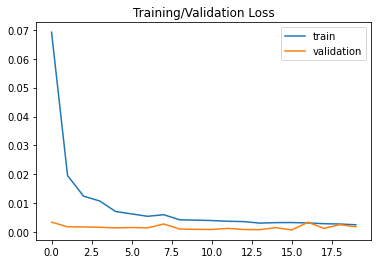

In [ ]:
# Visualize the training and validation loss
loss_df = pd.DataFrame({'train': history.history['loss'], 'validation': history.history['val_loss']})

loss_df.plot(title='Training/Validation Loss')

In [ ]:
# Evaluate the model >> model.metrics_names
model.evaluate(X_train, y_train , verbose=1)

3940/3940 [==============================] - 26s 7ms/step


0.011841343251444184

In [ ]:
# Building the array

X_test = []
y_test = test_data[60:, -3:-2]
timesteps = 60

for i in range(timesteps, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-timesteps:i, :])

# Converting x_train and y_train to Numpy arrays
X_test = np.array(X_test)


# Check the array size
X_test.shape

(940, 60, 16)

In [ ]:
y_test.shape, X_test.shape

((940, 1), (940, 60, 16))

In [ ]:
# Scale the data by transforming
y_pred = model.predict(X_test)
# create empty table with 16 fields
trainPredict_dataset_like = np.zeros(shape=(len(y_pred), 16))
# put the predicted values in the right field
trainPredict_dataset_like[:,-2] = y_pred[:,0]
# inverse transform and then select the right field


predicted_price = scaler.inverse_transform(trainPredict_dataset_like)[:,-2]
#predicted_price = scaler.inverse_transform(y_pred)
predicted_price[2], y_test[2]

(155.0858073771, array([147.79], dtype=object))

In [ ]:
rmse = np.sqrt(np.mean((predicted_price - y_test)**2))
rmse

20.97457820619198

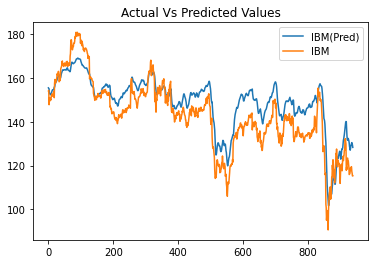

In [ ]:
result = pd.DataFrame(predicted_price)
result.columns = ['IBM(Pred)']
result['IBM'] = y_test

result.plot(title='Actual Vs Predicted Values')

In [ ]:
ibm_df.tail()

,date,SMA,EMA,RSI,Real Upper Band,Real Lower Band,Real Middle Band,MACD,MACD_Hist,MACD_Signal,CCI,ATR,1. open,2. high,3. low,4. close,5. volume
4995,2020-07-06,120.5714,120.6067,47.3451,132.1426,112.5634,122.3530,-1.2255,-0.2890,-0.9365,-37.3526,3.5480,121.25,121.85,119.46,120.19,4044200.0
4996,2020-07-07,120.0307,120.2031,43.1380,129.2673,113.6217,121.4445,-1.3553,-0.3350,-1.0203,-80.7584,3.5136,119.00,119.51,117.33,117.58,4278100.0
4997,2020-07-08,119.5707,119.8707,43.4077,127.0802,114.3928,120.7365,-1.4312,-0.3288,-1.1025,-95.6587,3.4459,118.06,118.64,116.48,117.71,5191800.0
4998,2020-07-09,118.9671,119.3160,40.2446,125.1866,114.8704,120.0285,-1.6339,-0.4252,-1.2087,-135.3397,3.4136,118.00,118.00,115.20,115.71,4760900.0
4999,2020-07-10,118.6729,119.1872,45.8535,125.1791,114.9119,120.0455,-1.5635,-0.2838,-1.2797,-86.9297,3.4069,115.50,118.57,115.29,118.35,4285100.0


In [ ]:
X_test[-1][-1, :]

array([0.3877769 , 0.39032544, 0.42000748, 0.36754899, 0.40715907,
       0.38988644, 0.45249371, 0.44745886, 0.48961843, 0.39023864,
       0.48724609, 0.39413924, 0.38505025, 0.38174559, 0.37727867,
       0.09291734])

In [ ]:
# Scale the data by transforming
y_pred = model.predict(X_test)
# create empty table with 16 fields
trainPredict_dataset_like = np.zeros(shape=(len(y_pred), 16))
# put the predicted values in the right field
trainPredict_dataset_like[:,-2] = y_pred[:,0]
# inverse transform and then select the right field


predicted_price = scaler.inverse_transform(trainPredict_dataset_like)[:,-2]
#predicted_price = scaler.inverse_transform(y_pred)


In [ ]:
predicted_price[-60:-1]

array([115.18831037, 113.75190448, 113.38046364, 113.38756261,
       111.40843052, 111.54380909, 113.08671388, 115.65076842,
       118.43096787, 120.79675904, 122.96101519, 123.82639   ,
       123.58582981, 123.14735114, 123.49430964, 124.35918628,
       124.83604345, 125.4989779 , 126.30668437, 126.52892233,
       125.15346602, 123.56750278, 122.90335163, 124.247241  ,
       125.82038586, 127.20052691, 127.67637816, 127.56460533,
       128.18105639, 129.8315139 , 131.56073548, 132.17199883,
       133.17303963, 134.23814359, 135.66377648, 136.79358548,
       138.14452591, 139.68159154, 140.12658478, 139.97997814,
       136.5054689 , 133.7461592 , 131.79834974, 131.53982178,
       131.99653168, 132.37486072, 131.87454151, 131.25780304,
       130.2754629 , 128.69667048, 127.97125839, 127.00668962,
       127.69054735, 128.93793482, 129.51822521, 130.03404048,
       130.47363525, 130.0576606 , 129.31686263])

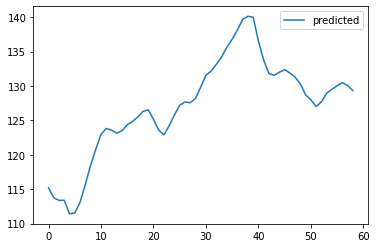

In [ ]:
prediction_df = pd.DataFrame({'predicted': predicted_price[-60: -1: 1]})
prediction_df.plot()

In [ ]:
prediction_df["price_direction"] = np.sign(prediction_df["predicted"].shift(-1) - prediction_df["predicted"])
prediction_df

,predicted,price_direction
0,115.188310,-1.0
1,113.751904,-1.0
2,113.380464,1.0
3,113.387563,-1.0
4,111.408431,1.0
5,111.543809,1.0
6,113.086714,1.0
7,115.650768,1.0
8,118.430968,1.0
9,120.796759,1.0


In [ ]:
old_pred_df = pd.DataFrame({'predicted': predicted_price, 'actual': y_test[:, 0]})
#old_pred_df["predicted_movement"] = np.sign(old_pred_df["predicted"].shift(-1) - old_pred_df["predicted"])
#old_pred_df["true_movement"] = np.sign(old_pred_df["actual"].shift(-1) - old_pred_df["actual"])
#old_pred_df["correct_prediction"] = df["predicted_movement"] - old_pred_df["true_movement#"]

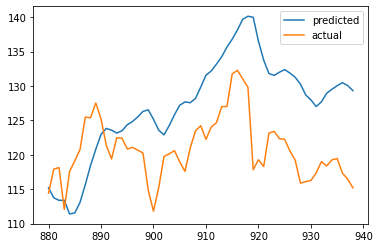

In [ ]:
old_pred_df.iloc[-60:-1].plot()